In [281]:
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score
from scipy.stats import zscore
import re

In [282]:
# Load processed dataset
train_data = pd.read_csv('./train_lol_cleaned.csv')
test_data = pd.read_csv('./test_lol_cleaned.csv')

# df for analysis, maintain integrity
data = train_data.copy()

資料平衡性檢查

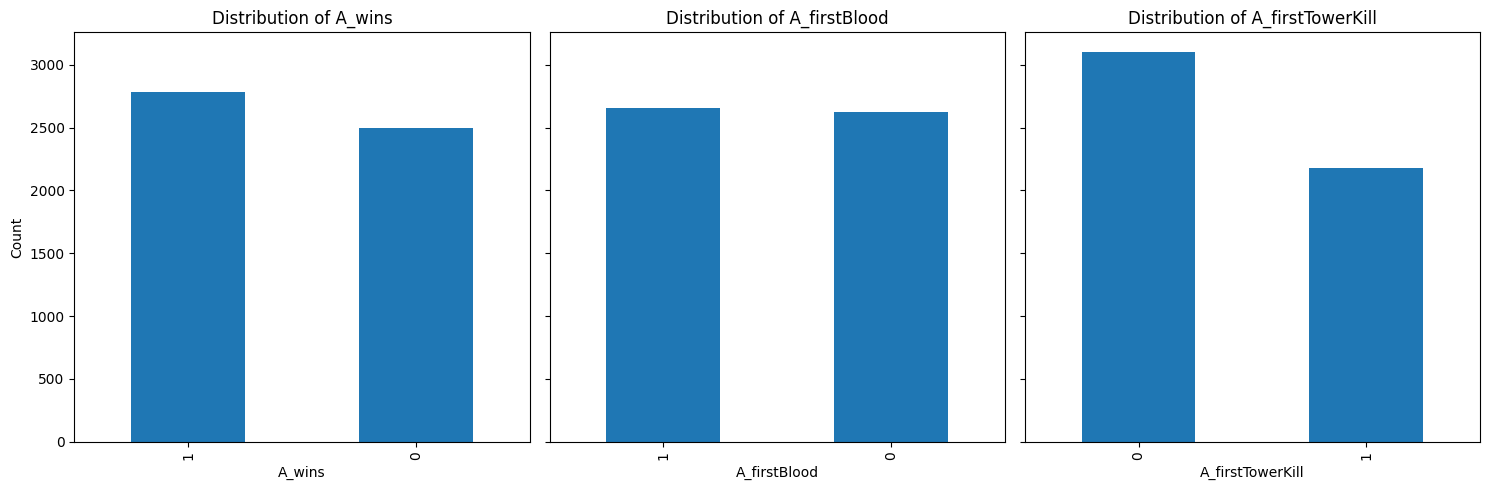

In [283]:
main_target_features = ["A_wins", "A_firstBlood", "A_firstTowerKill"]
target_features = ["A_wins", "A_firstBlood", "A_firstTowerKill", "B_firstBlood", "B_firstTowerKill"]

fig, axes = plt.subplots(1, 3, figsize=(15, 5), sharey=True)
for i, target in enumerate(main_target_features):
    data[target].value_counts().plot(kind='bar', ax=axes[i])
    axes[i].set_title(f"Distribution of {target}")
    axes[i].set_xlabel(target)
    axes[i].set_ylabel("Count")
plt.tight_layout()
plt.show()

處理缺失值

In [284]:
null_counts = data.isnull().sum()
null_percentage = (null_counts / len(data)) * 100

# 篩選有缺失值的特徵
null_features = null_percentage[null_percentage > 0]

# 列印有缺失值的特徵名稱及其缺失比例
if not null_features.empty:
    print("Features with missing values and their null percentages:")
    for feature, percentage in null_features.items():
        print(f"{feature}: {percentage:.2f}%")
else:
    print("No features have missing values.")

# 刪除有缺失值的列
missing_indices = data[data['A_jun_kills'].isnull()].index
data = data.drop(index=missing_indices)
train_data = train_data.drop(index=missing_indices)
test_data = test_data.drop(index=missing_indices)


Features with missing values and their null percentages:
A_jun_kills: 0.02%
A_jun_deaths: 0.02%
A_jun_assists: 0.02%
A_jun_level: 0.02%
A_jun_minionsKilled: 0.02%
A_jun_sight: 0.02%
A_jun_turretsKilled: 0.02%
A_jun_goldSpent: 0.02%
A_jun_totalHeal: 0.02%
A_jun_largestMultiKill: 0.02%
A_jun_largestKillingSpree: 0.02%
A_jun_totalDamageDealtToChampions: 0.02%
A_jun_totalDamageTaken: 0.02%
A_jun_totalTimeCrowdControlDealt: 0.02%
B_jun_kills: 0.02%
B_jun_deaths: 0.02%
B_jun_assists: 0.02%
B_jun_level: 0.02%
B_jun_minionsKilled: 0.02%
B_jun_sight: 0.02%
B_jun_turretsKilled: 0.02%
B_jun_goldSpent: 0.02%
B_jun_totalHeal: 0.02%
B_jun_largestMultiKill: 0.02%
B_jun_largestKillingSpree: 0.02%
B_jun_totalDamageDealtToChampions: 0.02%
B_jun_totalDamageTaken: 0.02%
B_jun_totalTimeCrowdControlDealt: 0.02%


離群值檢查

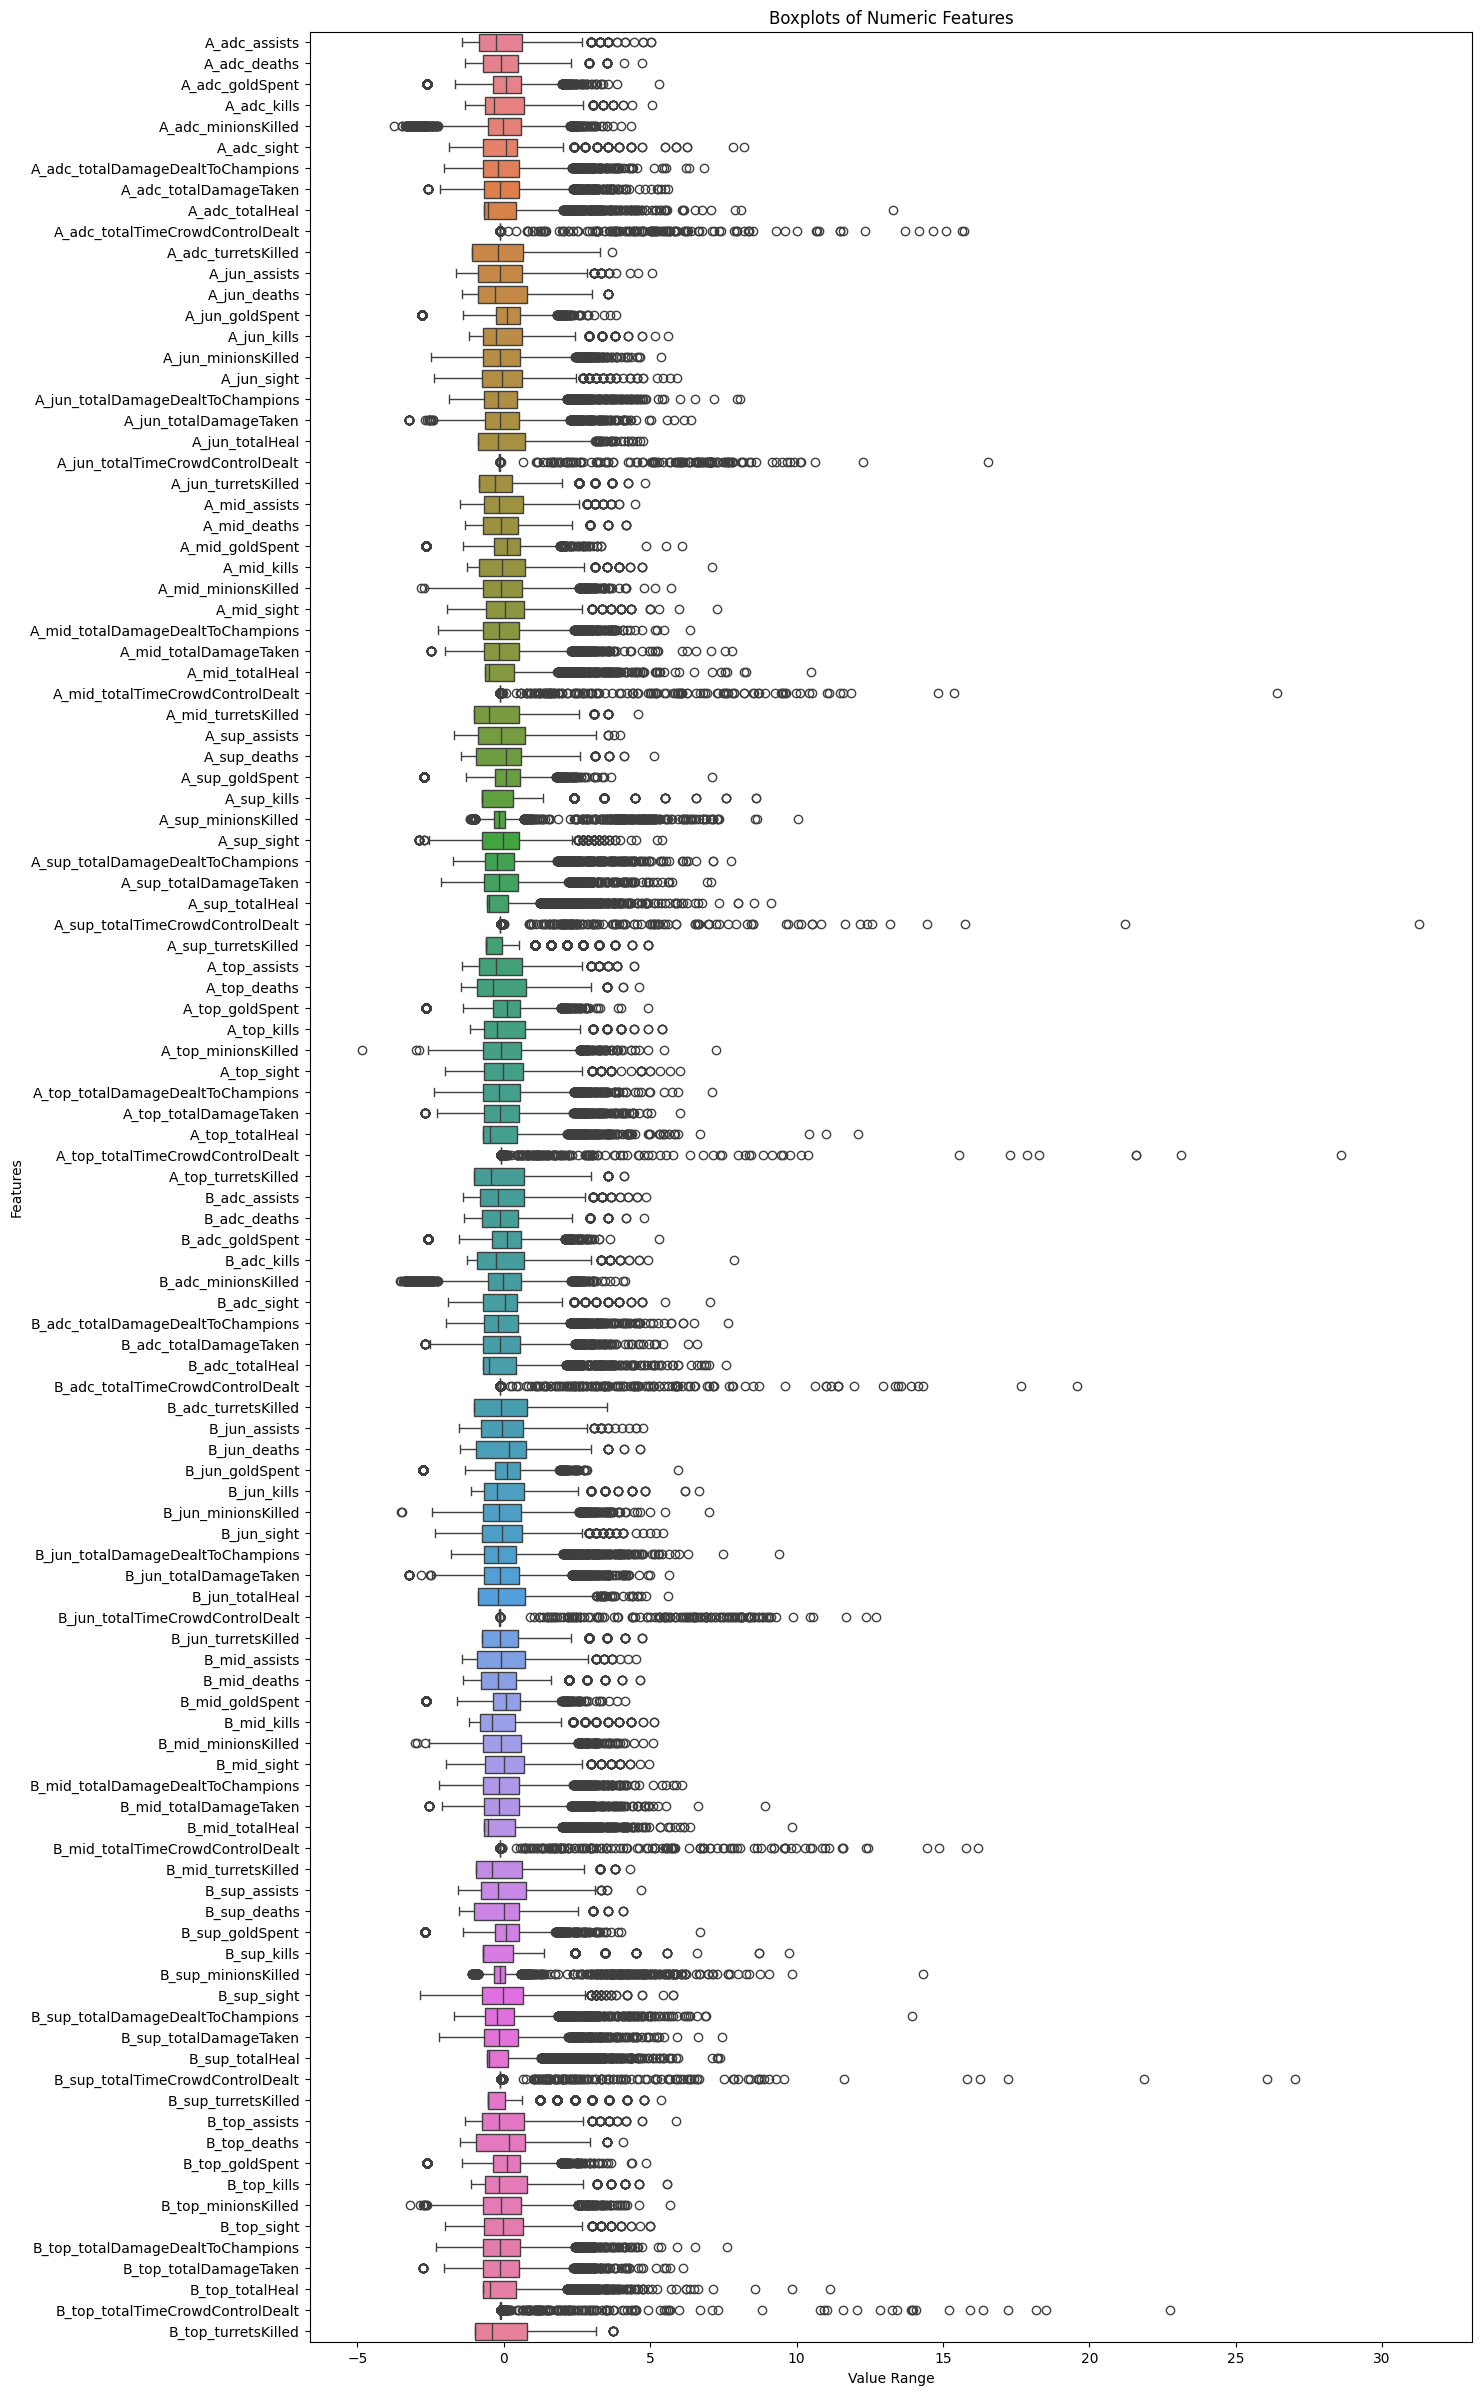

In [285]:
# 選擇沒有固定上限的數值型特徵
fixed_upper_limit_features = [
    col for col in data.columns 
    if re.match(r"^(A|B)_(top|mid|adc|sup|jun)_(level|largestKillingSpree|largestMultiKill)$", col) or 
       re.match(r"^(A|B)_(baron_kills|dragon_kills|herald_kills|elder_dragon_kills|voidgrubs)$", col)
]
numeric_features = data.select_dtypes(include=["float64", "int64"]).columns
numeric_features = data.select_dtypes(include=["float64", "int64"]).columns.difference(target_features + fixed_upper_limit_features)

# 因資料尺度落差較大，先做數據標準化
scaler = StandardScaler()
data[numeric_features] = scaler.fit_transform(data[numeric_features])

# 繪製box-plot
plt.figure(figsize=(15, 30))
sns.boxplot(data=data[numeric_features], orient="h")
plt.title("Boxplots of Numeric Features")
plt.xlabel("Value Range")
plt.ylabel("Features")
plt.show()

In [286]:
'''
為保留真實比賽數據，盡量不刪除離群值。
A/B_Role_totalTimeCrowdControlDealt這個特徵數據分布過於稀疏，故移除

'''
control_dealt = [col for col in data.columns if col.endswith('totalTimeCrowdControlDealt')]
data.drop(columns=control_dealt, axis=1, inplace=True)
train_data.drop(columns=control_dealt, axis=1, inplace=True)
test_data.drop(columns=control_dealt, axis=1, inplace=True)

隊伍勝負之特徵重要性分析

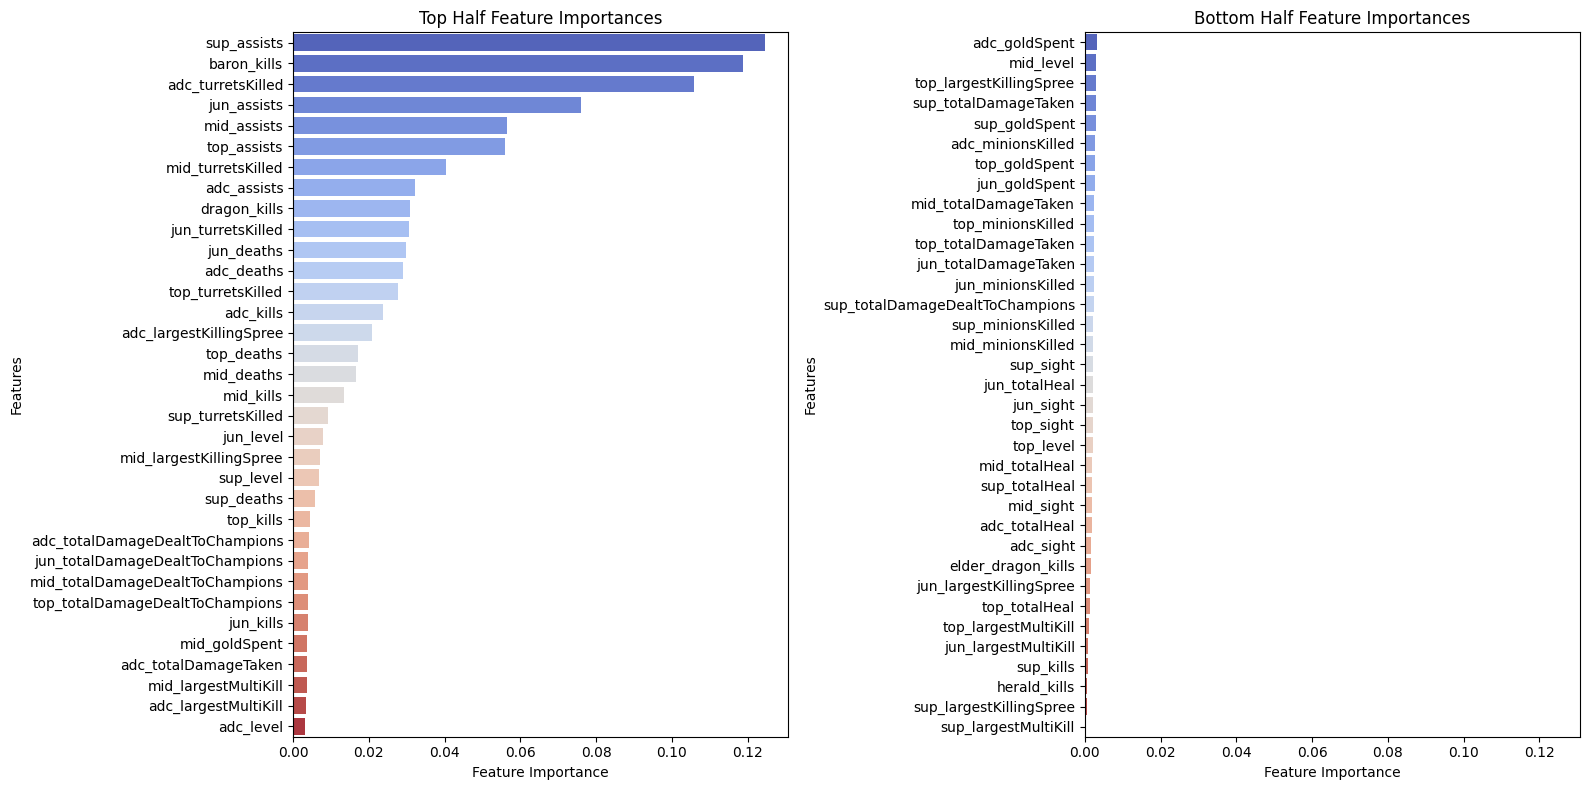

Median Importance: 0.003121783562025261
Low Importance Features: 'top_totalDamageTaken', 'jun_totalDamageTaken', 'jun_minionsKilled', 'sup_totalDamageDealtToChampions', 'sup_minionsKilled', 'mid_minionsKilled', 'sup_sight', 'jun_totalHeal', 'jun_sight', 'top_sight', 'top_level', 'mid_totalHeal', 'sup_totalHeal', 'mid_sight', 'adc_totalHeal', 'adc_sight', 'elder_dragon_kills', 'jun_largestKillingSpree', 'top_totalHeal', 'top_largestMultiKill', 'jun_largestMultiKill', 'sup_kills', 'herald_kills', 'sup_largestKillingSpree', 'sup_largestMultiKill'


In [287]:
X = data.drop(columns=['game_date', 'A_teamname', 'B_teamname'] + target_features)
y = data['A_wins']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 資料標準化
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# 訓練隨機森林分類器
rf = RandomForestClassifier(random_state=42, n_estimators=100)
rf.fit(X_train, y_train)

# 提取特徵重要性
feature_importances = pd.DataFrame({
    'Feature': X.columns,
    'Importance': rf.feature_importances_
})

# 合併相似特徵的重要性（A 和 B 隊伍）
feature_importances['BaseFeature'] = feature_importances['Feature'].str.replace(r'^[AB]_', '', regex=True)
grouped_importances = feature_importances.groupby('BaseFeature')['Importance'].sum().reset_index()

# 按特徵重要性排序
top_combined_features = grouped_importances.sort_values(by='Importance', ascending=False)

# 將特徵分為上下兩部分
mid_index = len(top_combined_features) // 2
top_half = top_combined_features.iloc[:mid_index]
bottom_half = top_combined_features.iloc[mid_index:]

# 繪製上下兩部分的特徵重要性
fig, axes = plt.subplots(1, 2, figsize=(16, 8), sharex=True)
sns.barplot(x='Importance', y='BaseFeature', hue='BaseFeature', data=top_half, ax=axes[0], palette='coolwarm', dodge=False, legend=False)
axes[0].set_title('Top Half Feature Importances')
axes[0].set_xlabel('Feature Importance')
axes[0].set_ylabel('Features')
sns.barplot(x='Importance', y='BaseFeature', hue='BaseFeature', data=bottom_half, ax=axes[1], palette='coolwarm', dodge=False, legend=False)
axes[1].set_title('Bottom Half Feature Importances')
axes[1].set_xlabel('Feature Importance')
axes[1].set_ylabel('Features')
plt.tight_layout()
plt.show()

# 取得top_combined_features的特徵重要性性中位數
median_importance = top_combined_features['Importance'].median()
print(f"Median Importance: {median_importance}")
# 列出重要性小於0.002的特徵
low_importance_features = top_combined_features[top_combined_features['Importance'] < 0.0025]
print(f"Low Importance Features: {", ".join([f"'{feature}'" for feature in low_importance_features['BaseFeature'].values])}")


In [288]:
"""
Feature Selection
a. 保留完整的特徵數據以進行全面繪圖和分析
b. 創建新 DataFrame 對數據進行逐步篩選，最終生成精簡的數據集，為後續模型分析提供高質量的基礎。
"""
# 刪除重要性低於0.0025的特徵，但保留地圖物件和sup_sight
# ['top_totalDamageTaken', 'jun_totalDamageTaken', 'jun_minionsKilled', 'sup_totalDamageDealtToChampions', 'sup_minionsKilled', 
#                           'mid_minionsKilled', 'jun_totalHeal', 'jun_sight', 'top_sight', 'top_level', 'mid_totalHeal', 'sup_totalHeal', 'mid_sight', 
#                           'adc_totalHeal', 'adc_sight', 'jun_largestKillingSpree', 'top_totalHeal', 'top_largestMultiKill', 
#                           'jun_largestMultiKill', 'sup_kills', 'sup_largestKillingSpree', 'sup_largestMultiKill']
low_importance_feature =  ['top_totalHeal', 'sup_sight', 'sup_totalHeal', 'adc_sight', 'mid_sight', 'sup_largestKillingSpree',
                            'mid_largestMultiKill', 'top_sight', 'jun_totalHeal', 'adc_totalHeal', 'sup_largestMultiKill',
                            'jun_largestKillingSpree', 'top_largestMultiKill', 'mid_totalHeal','sup_kills', 'jun_largestMultiKill',]

for side in ["A", "B"]:
    for feat in low_importance_feature:
        column_name = f"{side}_{feat}"
        if column_name in train_data.columns:
            train_data.drop(columns=[column_name], inplace=True)
        if column_name in test_data.columns:
            test_data.drop(columns=[column_name], inplace=True)

# 輸出特徵篩選後的資料
train_data.to_csv("train_lol_selected.csv", index=False)
test_data.to_csv("test_lol_selected.csv", index=False)

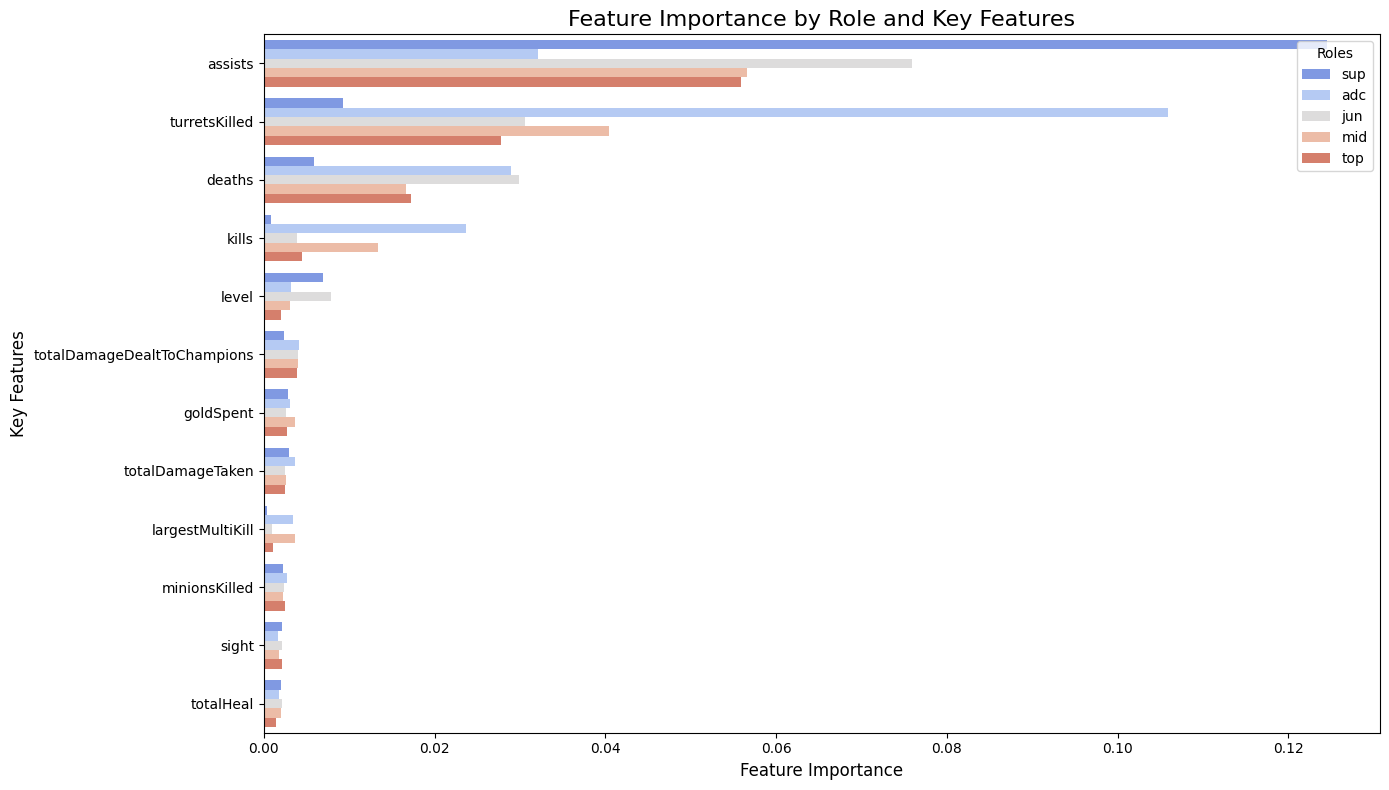

In [289]:
# 將特徵按角色分類
feature_importances['Role'] = feature_importances['BaseFeature'].str.extract(r'(top|jun|mid|adc|sup)')
feature_importances['KeyFeature'] = feature_importances['BaseFeature'].str.extract(
    r'(kills|deaths|assists|level|goldSpent|minionsKilled|sight|turretsKilled|totalHeal|totalDamageTaken|totalDamageDealtToChampions|largestMultiKill)'
    )

# 計算每個角色對於每種關鍵特徵的重要性總和
role_feature_importance = feature_importances.groupby(['Role', 'KeyFeature'])['Importance'].sum().reset_index()

# 篩選有意義的 KeyFeature
role_feature_importance = role_feature_importance.dropna().sort_values(by='Importance', ascending=False)

# 可視化每個角色對不同關鍵特徵的重要性
plt.figure(figsize=(14, 8))
sns.barplot(
    x='Importance', y='KeyFeature', hue='Role',
    data=role_feature_importance, palette='coolwarm', dodge=True
)
plt.title('Feature Importance by Role and Key Features', fontsize=16)
plt.xlabel('Feature Importance', fontsize=12)
plt.ylabel('Key Features', fontsize=12)
plt.legend(title='Roles', loc='upper right', fontsize=10)
plt.tight_layout()
plt.show()

角色重要性分析

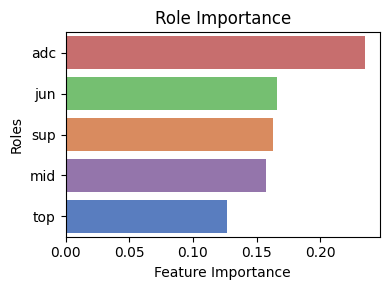

In [290]:
# 合併相似特徵的重要性（以角色 Role 合併）
feature_importances['RoleFeature'] = feature_importances['Feature'].str.extract(r'_(top|mid|adc|sup|jun)_')
grouped_importances = feature_importances.groupby('RoleFeature')['Importance'].sum().reset_index()

# 按特徵重要性排序
top_combined_features = grouped_importances.sort_values(by='Importance', ascending=False)

# 繪製角色重要性
muted_palette = sns.color_palette('muted', 5)  # 提取 5 種顏色
custom_palette = {
    'top': muted_palette[0],  # 第一種顏色
    'sup': muted_palette[1],  # 第二種顏色
    'jun': muted_palette[2],  # 第三種顏色
    'adc': muted_palette[3],  # 第四種顏色
    'mid': muted_palette[4]   # 第五種顏色
}
plt.figure(figsize=(4,3))
sns.barplot(x='Importance', y='RoleFeature', hue='RoleFeature', data=top_combined_features, palette=custom_palette, dodge=False)
plt.title('Role Importance')
plt.xlabel('Feature Importance')
plt.ylabel('Roles')
plt.tight_layout()
plt.show()

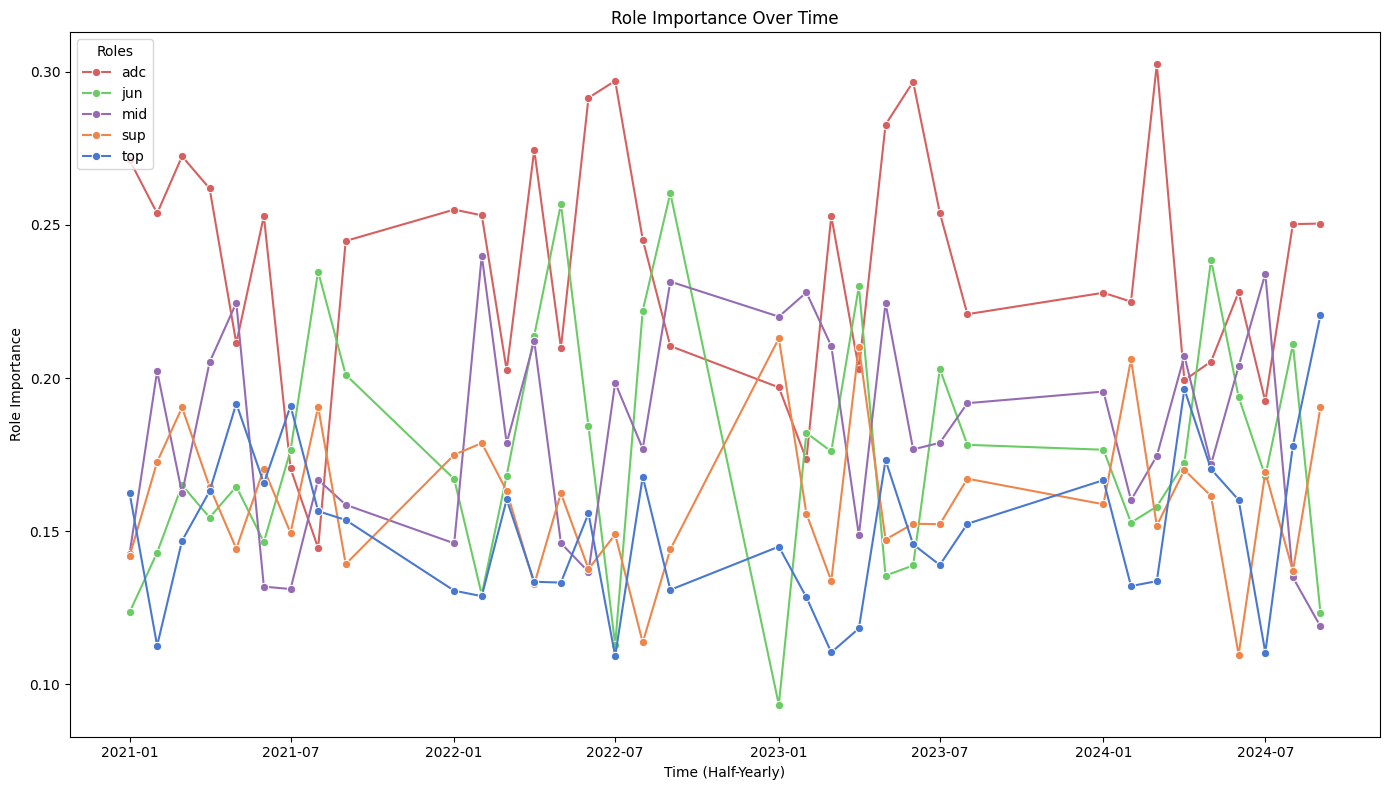

In [291]:
# 定義特徵和目標變數
X = data.drop(columns=['game_date', 'A_teamname', 'B_teamname'] + target_features)
y = data['A_wins']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 資料標準化（僅對數值型特徵）
scaler = StandardScaler()
numeric_features = X.select_dtypes(include=['float64', 'int64']).columns
X_train_scaled = pd.DataFrame(scaler.fit_transform(X_train[numeric_features]), columns=numeric_features, index=X_train.index)
X_test_scaled = pd.DataFrame(scaler.transform(X_test[numeric_features]), columns=numeric_features, index=X_test.index)

# 加入時間序列資料
data['game_date'] = pd.to_datetime(data['game_date'], errors='coerce').dt.tz_localize(None)
data = data.assign(HalfYear=data['game_date'].dt.to_period('6M'))

# 按半年分組資料
data_groups = []
for half_year, group in data.groupby('HalfYear'):
    group_indices = group.index
    X_group = X_train_scaled.loc[group_indices.intersection(X_train.index)]
    y_group = y_train.loc[group_indices.intersection(y_train.index)]
    if not X_group.empty:  # 確保分組資料不為空
        data_groups.append((half_year.start_time, X_group, y_group))

# 訓練 Random Forest 並分析每半年的特徵重要性
all_feature_importances = []
for half_year, X_group, y_group in data_groups:
    rf = RandomForestClassifier(random_state=42, n_estimators=100)
    rf.fit(X_group, y_group)

    feature_importances_group = pd.DataFrame({
        'Feature': X_group.columns,
        'Importance': rf.feature_importances_
    })
    feature_importances_group['HalfYear'] = half_year
    all_feature_importances.append(feature_importances_group)

# 合併所有的特徵重要性結果
combined_feature_importances = pd.concat(all_feature_importances)
combined_feature_importances['BaseFeature'] = combined_feature_importances['Feature'].str.replace(r'^[AB]_', '', regex=True)
combined_feature_importances['Role'] = combined_feature_importances['BaseFeature'].str.extract(r'(top|jun|mid|adc|sup)_')

# 按角色和時間計算總特徵重要性
role_importances_over_time = combined_feature_importances.groupby(['HalfYear', 'Role'])['Importance'].sum().reset_index()
role_importances_over_time['SmoothedImportance'] = role_importances_over_time.groupby('Role')['Importance'].transform(lambda x: x.rolling(window=3, min_periods=1).mean())

# 繪製角色重要性隨時間的變化圖
plt.figure(figsize=(14, 8))
sns.lineplot(x='HalfYear', y='Importance', hue='Role', data=role_importances_over_time, marker='o', palette=custom_palette)
plt.title('Role Importance Over Time')
plt.xlabel('Time (Half-Yearly)')
plt.ylabel('Role Importance')
plt.legend(title='Roles', loc='upper left')
plt.tight_layout()
plt.show()

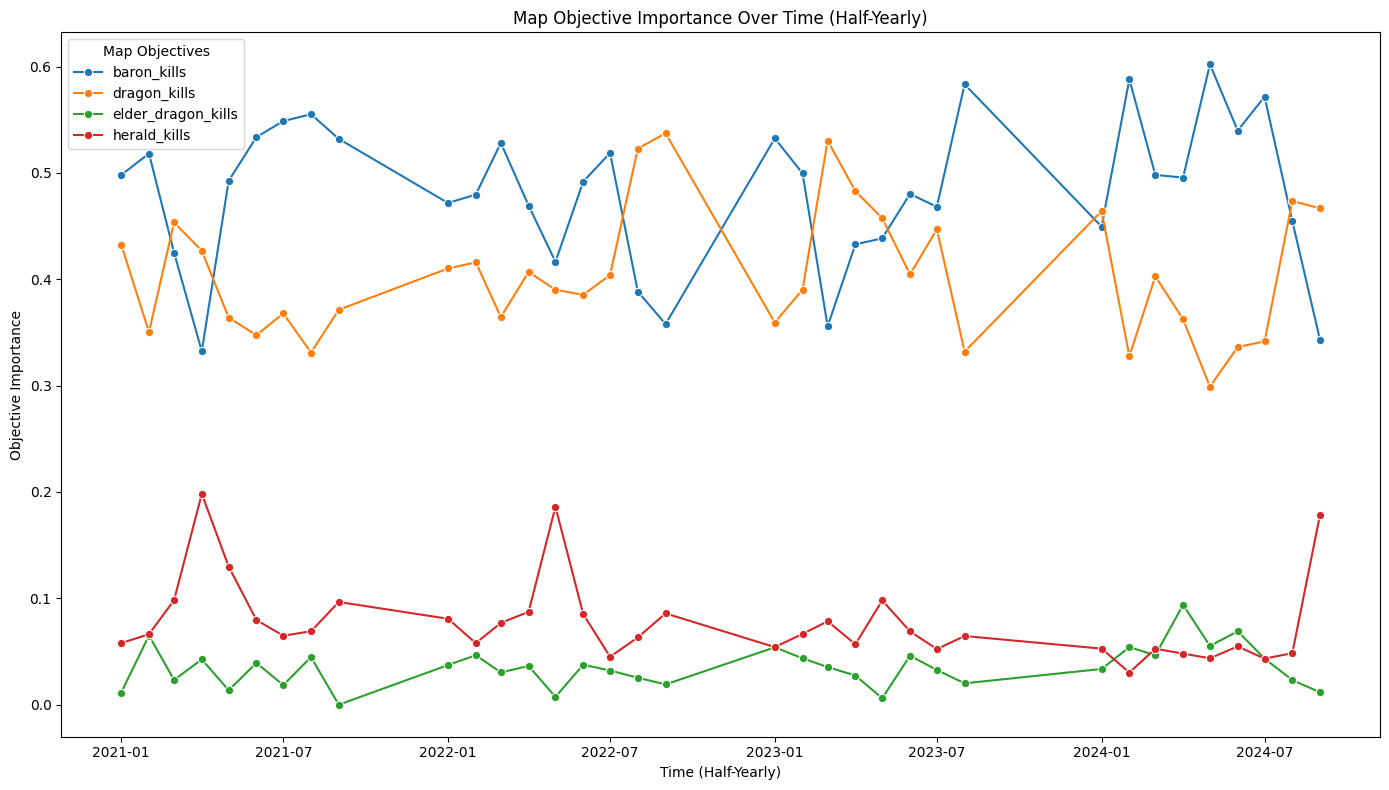

In [292]:
# 定義地圖物件特徵
map_object_features = ['baron_kills', 'dragon_kills', 'elder_dragon_kills', 'herald_kills']

# 加入時間序列資料
data['game_date'] = pd.to_datetime(data['game_date'], errors='coerce')
data['game_date'] = data['game_date'].dt.tz_localize(None)
data['HalfYear'] = data['game_date'].dt.to_period('6M')

# 將特徵分組並創建數據組
data_groups = []
for half_year, group in data.groupby('HalfYear'):
    X_group = group[[f"A_{feat}" for feat in map_object_features] + [f"B_{feat}" for feat in map_object_features]]
    y_group = group['A_wins']
    if not X_group.empty:  # 確保分組資料不為空
        data_groups.append((half_year.start_time, X_group, y_group))

# 訓練隨機森林模型並分析每半年地圖物件的重要性
all_feature_importances = []
for half_year, X_group, y_group in data_groups:
    rf = RandomForestClassifier(random_state=42, n_estimators=100)
    rf.fit(X_group, y_group)

    feature_importances_group = pd.DataFrame({
        'Feature': X_group.columns,
        'Importance': rf.feature_importances_
    })
    feature_importances_group['HalfYear'] = half_year
    all_feature_importances.append(feature_importances_group)

# 合併所有特徵重要性結果
combined_feature_importances = pd.concat(all_feature_importances)
combined_feature_importances['BaseFeature'] = combined_feature_importances['Feature'].str.replace(r'^[AB]_', '', regex=True)

# 按地圖物件類型分組並計算總重要性
object_importances_over_time = combined_feature_importances.groupby(['HalfYear', 'BaseFeature'])['Importance'].sum().reset_index()

# 繪製地圖物件重要性隨時間變化的折線圖
plt.figure(figsize=(14, 8))
sns.lineplot(x='HalfYear', y='Importance', hue='BaseFeature', data=object_importances_over_time, marker='o')
plt.title('Map Objective Importance Over Time (Half-Yearly)')
plt.xlabel('Time (Half-Yearly)')
plt.ylabel('Objective Importance')
plt.legend(title='Map Objectives', loc='upper left')
plt.tight_layout()
plt.show()


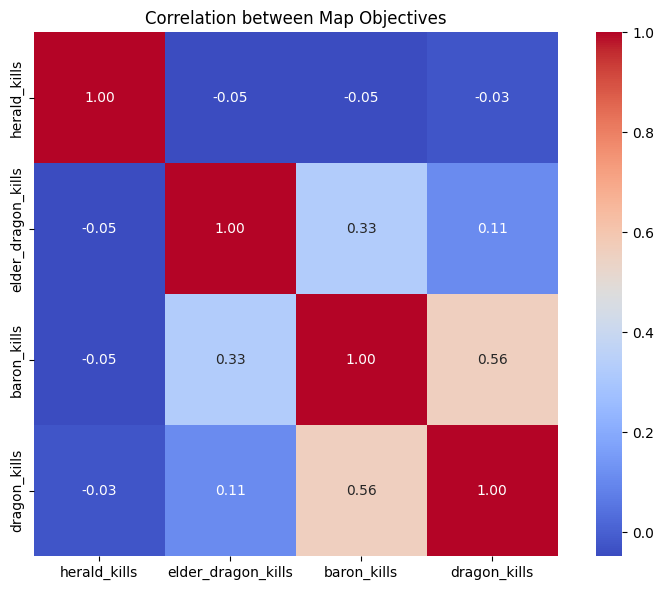

In [293]:
# 選取特徵的資料，並複製以避免鏈式賦值
df_corr = data[[  
    'HalfYear', 
    'A_herald_kills', 'B_herald_kills', 
    'A_elder_dragon_kills', 'B_elder_dragon_kills', 
    'A_baron_kills', 'B_baron_kills', 
    'A_dragon_kills', 'B_dragon_kills'
]].copy()

# 合併 A 和 B 隊伍的數據
df_corr['herald_kills'] = df_corr['A_herald_kills'] + df_corr['B_herald_kills']
df_corr['elder_dragon_kills'] = df_corr['A_elder_dragon_kills'] + df_corr['B_elder_dragon_kills']
df_corr['baron_kills'] = df_corr['A_baron_kills'] + df_corr['B_baron_kills']
df_corr['dragon_kills'] = df_corr['A_dragon_kills'] + df_corr['B_dragon_kills']

# 計算相關性
correlation_matrix = df_corr[['herald_kills', 'elder_dragon_kills', 'baron_kills', 'dragon_kills']].corr()

# 繪製熱力圖
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', square=True)
plt.title('Correlation between Map Objectives')
plt.tight_layout()
plt.show()

分析單一隊伍(需重新整理資料)

In [294]:
# 資料集重新整理: 每列只包含一個隊伍的資料，`teamname` 列表示隊伍名稱，`wins` 表示該隊伍的勝負
# A隊伍用teamname重新命名特徵
team_a_data = data.copy()
team_a_data.columns = [
    col.replace('A_', '').replace('B_', '') if col.startswith('A_') else col
    for col in team_a_data.columns
]
team_a_data = team_a_data.rename(columns={'A_teamname': 'teamname', 'A_wins': 'wins'})

# B隊伍用teamname重新命名特徵
team_b_data = data.copy()
team_b_data['B_wins'] = 1 - data['A_wins']  # 若 A_wins 是 1，則 B_wins 為 0，反之亦然
team_b_data.columns = [
    col.replace('B_', '').replace('A_', '') if col.startswith('B_') else col
    for col in team_b_data.columns
]
team_b_data = team_b_data.rename(columns={'B_teamname': 'teamname', 'B_wins': 'wins'})

# 刪除多餘的資料
if 'B_teamname' in team_a_data.columns:
    team_a_data = team_a_data.drop(columns=['B_teamname'])
if 'A_teamname' in team_b_data.columns:
    team_b_data = team_b_data.drop(columns=['A_teamname'])

# 合併 A 和 B 資料集
common_columns = team_a_data.columns.intersection(team_b_data.columns)
team_a_data = team_a_data[common_columns]
team_b_data = team_b_data[common_columns]
combined_data = pd.concat([team_a_data, team_b_data], ignore_index=True)
combined_data = combined_data.sort_values(by=['teamname', 'game_date']).reset_index(drop=True)


隊伍勝率分析

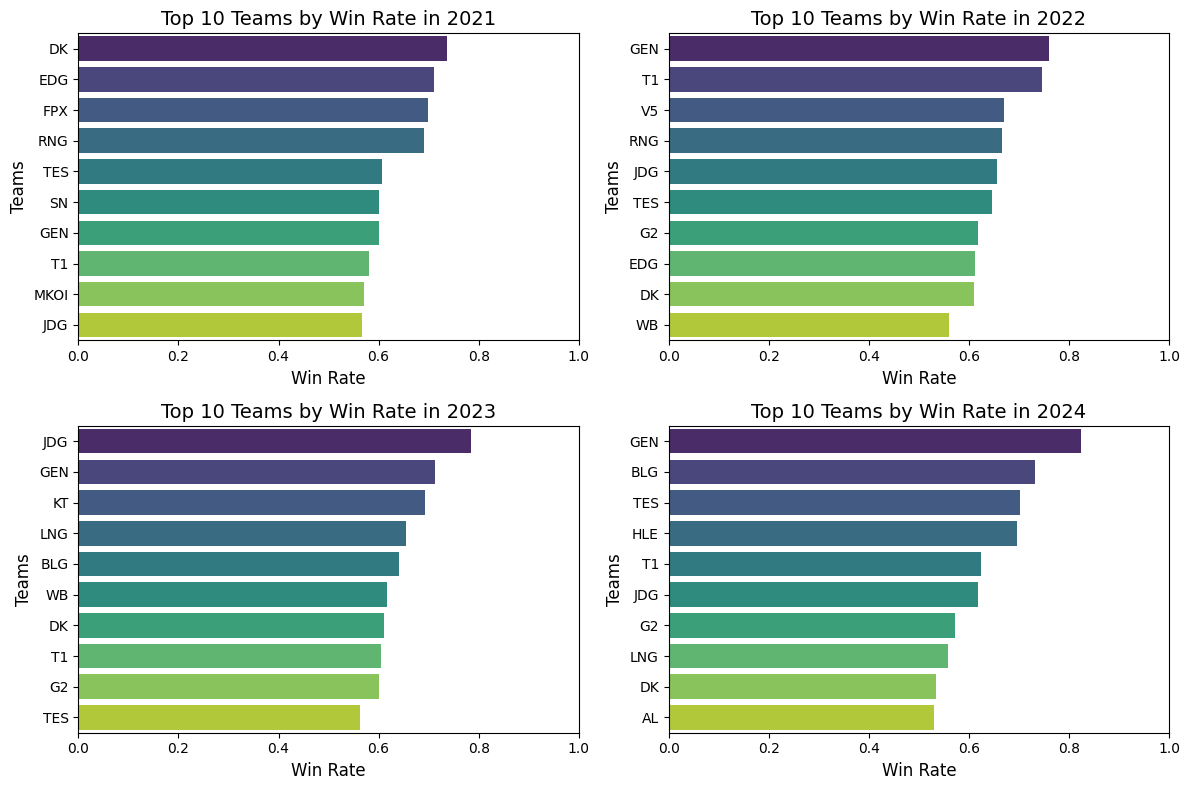

In [295]:
# 確保 'game_date' 是 datetime 並移除時區
combined_data['game_date'] = pd.to_datetime(combined_data['game_date'], errors='coerce')
combined_data['game_date'] = combined_data['game_date'].dt.tz_localize(None)
# 提取年份
combined_data['YearMonth'] = combined_data['game_date'].dt.to_period('M')  # 按月
combined_data['Year'] = combined_data['game_date'].dt.year  # 提取年份

# 計算每隊每年的勝率
win_rate_by_team_year = combined_data.groupby(['teamname', 'Year'])['wins'].mean().reset_index()
years = win_rate_by_team_year['Year'].unique()

# 繪製圖表
fig, axes = plt.subplots(2, 2, figsize=(12, 8))
axes = axes.flatten()
for i, year in enumerate(years):
    data_year = win_rate_by_team_year[win_rate_by_team_year['Year'] == year]
    data_year = data_year.sort_values(by='wins', ascending=False).head(10)  #僅繪製勝率前15的隊伍

    sns.barplot(x='wins', y='teamname', hue='teamname', data=data_year, ax=axes[i], palette='viridis', dodge=False)
    axes[i].set_title(f'Top 10 Teams by Win Rate in {year}', fontsize=14)
    axes[i].set_xlabel('Win Rate', fontsize=12)
    axes[i].set_ylabel('Teams', fontsize=12)
    axes[i].set_xlim(0, 1)

plt.tight_layout()
plt.show()

隊伍滾動式勝率趨勢圖

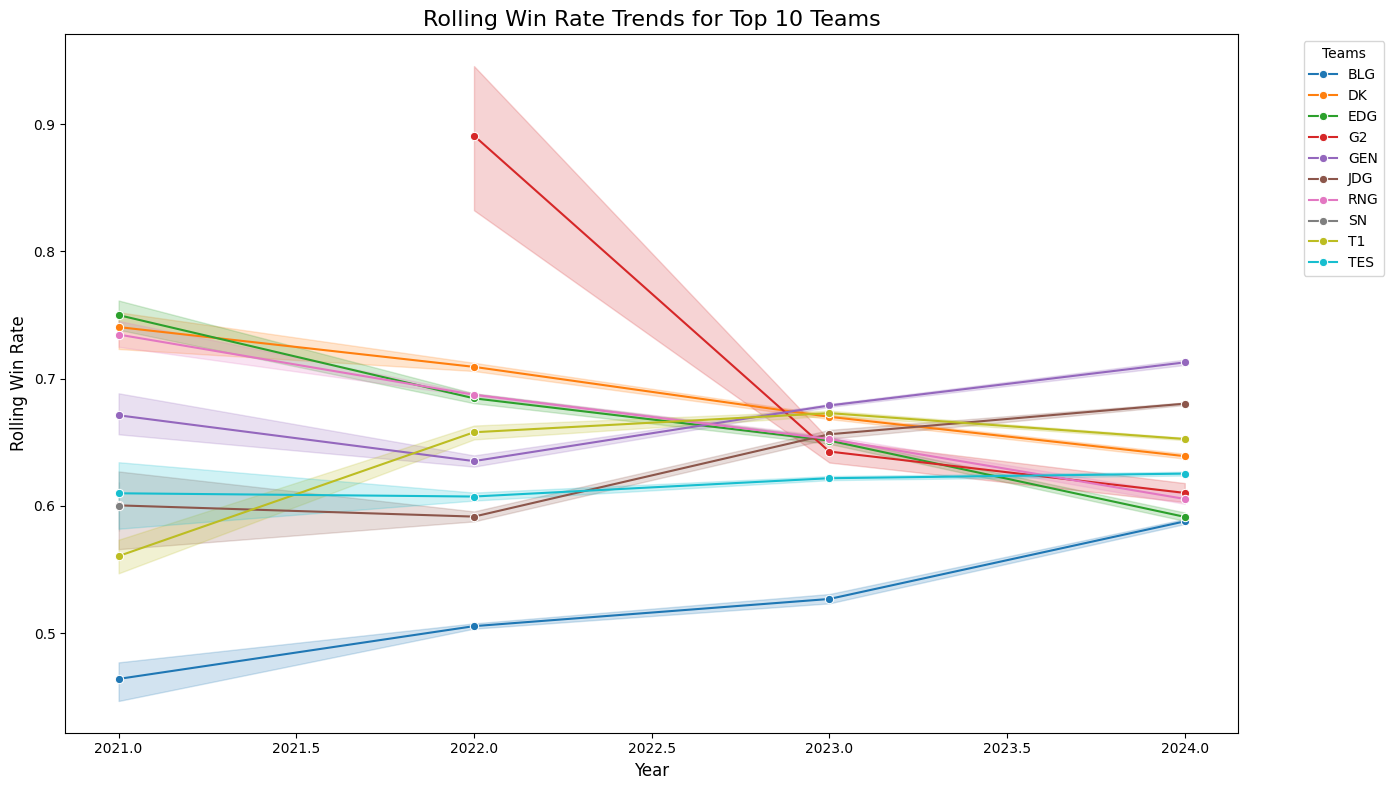

In [296]:
# 確保年份資訊存在
combined_data['Year'] = combined_data['YearMonth'].dt.year

# 計算滾動式勝率
combined_data = combined_data.sort_values(by=['teamname', 'Year'])  # 確保按隊伍和年份排序
combined_data['rolling_win_rate'] = combined_data.groupby('teamname')['wins'].transform(lambda x: x.expanding().mean())

# 取得前10支隊伍
overall_win_rate = combined_data.groupby('teamname')['wins'].mean().reset_index()
overall_win_rate = overall_win_rate.sort_values(by='wins', ascending=False).head(10)
top_teams = overall_win_rate['teamname']

# 篩選前10支隊伍的數據
top_teams_data = combined_data[combined_data['teamname'].isin(top_teams)]

# 繪製滾動式勝率趨勢圖
plt.figure(figsize=(14, 8))
sns.lineplot(
    x='Year', y='rolling_win_rate', hue='teamname', data=top_teams_data, marker='o', palette='tab10'
)
plt.title('Rolling Win Rate Trends for Top 10 Teams', fontsize=16)
plt.xlabel('Year', fontsize=12)
plt.ylabel('Rolling Win Rate', fontsize=12)
plt.legend(title='Teams', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()